# Multidimensional scaling for genetic population differences.

## In this exercise, we will look at a dataset of 42 human geographic populations collected by Cavalli-Sforza et al. in The History and Geography of Human Genes, 1994.  There are many ways to measure genetic similarity between populations.   This  work  uses  the modified  Nei’s  distance, which  compares  allele  frequencies  at specific locations within the human genome.  Other ways to measure genetic similarity include the edit distance between DNA sequences or Euclidean distance of gene expressions.

In [321]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.manifold import MDS

In [322]:
import numpy as np
data = np.load("mds-population.npz")
dis_array = data['D'] # Distance matrix
pop_list = data['population_list'] # List of populations

In [323]:
print(data.files)

['D', 'population_list']


In [324]:
np.shape(data['D'])

(42, 42)

In [325]:
np.shape(data['population_list'])

(42,)

###  (i) MDS will attempt to output a set of points x∈R42,m such that the Euclidean distance between every pair of points approximates the Nei’s distance between these populations, or ‖xi−xi‖2≈Di,j. What assumptions are being made? Underwhat circumstances could this fail? How could we measure how much information is being lost? Please explain.

#### The assumption here is likely that the genertic similarity is linearly correlated. In other words, if the dis-similarity/distance is 2x, the genes are 2x dis-similar. This could fail if the gene similarity did not adhere to the linear pattern. In other words, maybe a large population from Africa moved to Asia at a certain period. We could measure information lost using entropy.

### (ii) One way of increasing the quality of the output is by increasing the dimensionality of the MDS result.  How many dimensions are necessary to capture most of the variation in the data?   There are several ways of making this judgment:  for instance,  you might sample some quality measure between x and D while varying m, or you might count thenonzero singular values of D, or inspect the singular values of xat some high dimension likem=20. Briefly explain your method and justify why it makes sense.

<Container object of 5 artists>

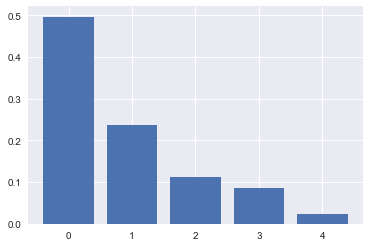

In [326]:
from sklearn.decomposition import PCA
n=5
pca = PCA(n_components=n)
pca.fit(data['D'])
pca.explained_variance_ratio_
plt.bar(range(n),pca.explained_variance_ratio_)

#### Since MDS approximates the Nei's distance using Euclidean distance, this approach appears similar to PCA. By varying m, the number of dimensions and applying PCA, we see that m=5 appears to capture more 95% of the variance. Hence m=5 is a reasonable estimation.

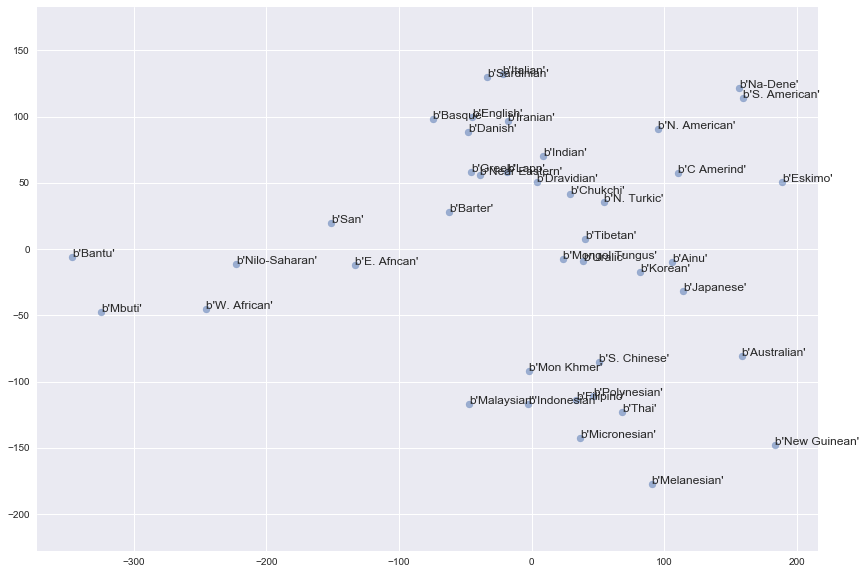

In [327]:
model = MDS(n_components=2, dissimilarity='precomputed', metric=True)
out = model.fit_transform(dis_array)
x, y = out[:, 0], out[:, 1]
fig, scatter_plot = plt.subplots(figsize=(14, 10))
scatter_plot.scatter(x, y, cmap="jet", alpha=0.5)
plt.axis('equal');
for index, data in enumerate(pop_list):
    scatter_plot.annotate(str(data),(x[index], y[index]))

## (b) k -means  on  2D  embedding.   Select  an  appropriate k and  run k-means  on  the  scatterplot. Show the resulting clusters. Since we are working with only two dimensions, this clustering is likely to lose a lot of high-dimensional structure.  Do you agree with the resulting clustering?  What information seems to be lost?

In [328]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(out)  

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [329]:
print(kmeans.cluster_centers_)  

[[  61.21834362    1.23637774]
 [-237.39868671  -17.20679108]
 [  56.03990048 -118.8084871 ]
 [ -32.79996731   80.47059459]
 [ 142.36121474   86.9191895 ]]


In [330]:
print(kmeans.labels_)

[1 1 1 1 1 3 1 3 3 3 0 0 0 0 2 2 3 0 0 2 2 2 0 2 3 3 3 3 3 3 3 4 4 4 4 4 0
 2 2 2 2 2]


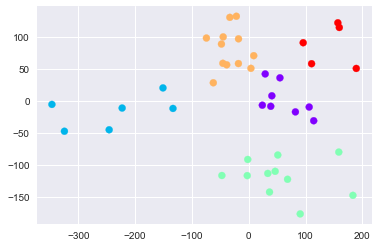

In [331]:
plt.scatter(x,y, c=kmeans.labels_, cmap='rainbow')

In [332]:
from collections import defaultdict
d = defaultdict(list)
for (ind, label) in enumerate(kmeans.labels_):
    d[label].append(pop_list[ind])
for temp in d.values():
    print(temp)

[b'Bantu', b'E. Afncan', b'Nilo-Saharan', b'W. African', b'San', b'Mbuti']
[b'Barter', b'Indian', b'Iranian', b'Near Eastern', b'Dravidian', b'Basque', b'Lapp', b'Sardinian', b'Danish', b'English', b'Greek', b'Italian']
[b'Uralic', b'Ainu', b'Japanese', b'Korean', b'Mongol Tungus', b'Tibetan', b'N. Turkic', b'Chukchi']
[b'Mon Khmer', b'Thai', b'Indonesian', b'Malaysian', b'Filipino', b'S. Chinese', b'Melanesian', b'Micronesian', b'Polynesian', b'New Guinean', b'Australian']
[b'C Amerind', b'Eskimo', b'Na-Dene', b'N. American', b'S. American']


#### 5 Clusters were picked based on the variance analysis from the PCA. The five clusters appear to segment the populations reasonable well. Many of the regional similarities are captured well in the clusters, however some of the clusters (e.g. pooling Iranian, Indian and Danish) may not be right.  While the regional similarity seems to have been captured, the language dissimilarity does not appear to be not addressed by the clusters.

## (c) Comparing hierarchical clustering with K-Means. Use hierarchical clustering to cluster the original distance matrix.  We suggest using the functions in scipy.cluster.hierarchy for this, as this library can plot the resulting graph structure.  Show the resulting tree as a dendrogram, labeling the x axis with the categorical population names and the y axis with the Nei’s distance between clusters. (It’s also possible to do this with sklearn, but traversing the resulting structure is much harder).
## To turn the resulting tree into a flat clustering of points, cut off the dendrogram at a certain distance by merging all subclusters within this distance together.  This can be done with the scipy.cluster.hierarchy.fcluster function. Select a distance cutoff that roughly corresponds with your chosen k earlier, balancing the number of points in each cluster with the number of resulting clusters. Visualize the resulting clustering by coloring the corresponding points on your 2D MDS embedding.   How does this clustering compare with the k-means clustering you computed earlier?

In [333]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.spatial.distance as ssd

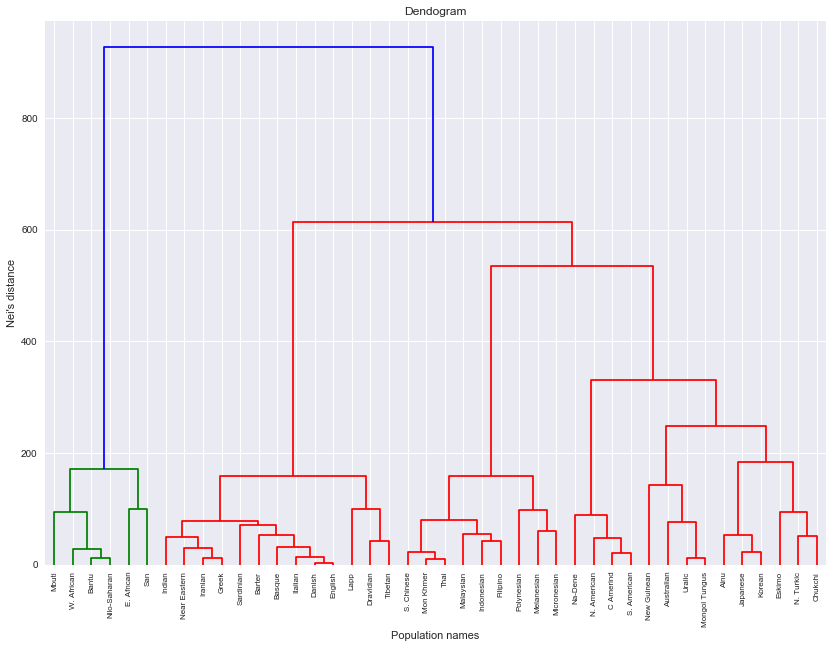

In [334]:
# Create Model for K-Means
eucdis_array = ssd.squareform(dis_array)
kmeans_model = linkage(eucdis_array,'ward', metric='precomputed')
plt.figure(figsize=(14, 10))  
plt.title("Dendogram")
plt.xlabel("Population names")
plt.ylabel("Nei's distance")
dend = dendrogram(kmeans_model, labels = [x.decode('UTF-8') for x in pop_list])  

Text(0.5,1,'Hierarchial Clustering')

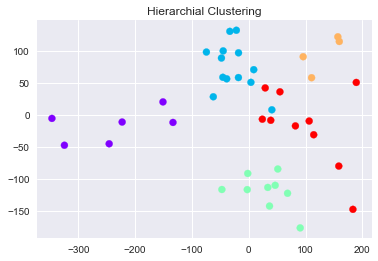

In [335]:
assignments = fcluster(kmeans_model,300,'distance')
plt.scatter(x,y, c=assignments, cmap='rainbow')
plt.title("Hierarchial Clustering")

Text(0.5,1,'K-Means')

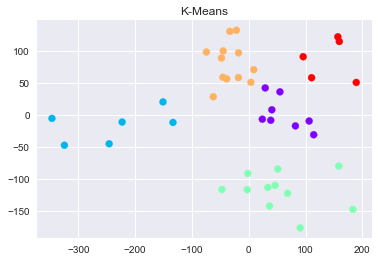

In [336]:
plt.scatter(x,y, c=kmeans.labels_, cmap='rainbow')
plt.title("K-Means")

#### The K-means and Hierarchial clustering are similar, however, the K-means classifies points on the edge of the cluster better. (e.g. There's a blue point stuck in between in two reds on the Hierarchial clustering, Also a red in the Orange cluster)

### (d) Compare k -medoids with k -means. Repeat the above experiment,  but applying k-medoid clustering on the original distance matrix.  Show the resulting clusters on a 2D scatterplot. Are there any significant differences between the clustering chosen by k-medoids compared to k-means?

In [337]:
#This code is from:
#Bauckhage C. Numpy/scipy Recipes for Data Science: k-Medoids Clustering[R]. Technical Report, University of Bonn, 2015.
from medoids import k_medoids

In [338]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import metric

In [362]:
initial_medoids = [0,10,20,30,35]

In [363]:
dis_array

array([[  0.,  87.,  12., ..., 462., 559., 553.],
       [ 87.,   0.,  87., ..., 210., 359., 285.],
       [ 12.,  87.,   0., ..., 317., 401., 377.],
       ...,
       [462., 210., 317., ...,   0., 226., 173.],
       [559., 359., 401., ..., 226.,   0., 127.],
       [553., 285., 377., ..., 173., 127.,   0.]])

In [364]:
#metric = metric.distance_metric(metric.type_metric.MINKOWSKI, degree=2)
kmedoids_instance = kmedoids(dis_array, initial_medoids, data_type='distance_matrix')

In [365]:
kmedoids_instance.process();
clusters = kmedoids_instance.get_clusters()

kmedoids_cluster = []
for c in range(len(clusters)):
    for p in range(len(clusters[c])):
        kmedoids_cluster.append(c)
        
for c in range(len(clusters)):
    for p in clusters[c]:
        kmedoids_cluster[p] = c
        
print(clusters)

print(kmedoids_cluster)

[[2, 0, 1, 3, 4, 6], [17, 10, 11, 12, 13, 16, 18, 22, 32, 36, 40, 41], [23, 14, 15, 19, 20, 21, 37, 38, 39], [29, 5, 7, 8, 9, 24, 25, 26, 27, 28, 30], [31, 33, 34, 35]]
[0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 1, 4, 4, 4, 1, 2, 2, 2, 1, 1]


Text(0.5,1,'K-Medoids')

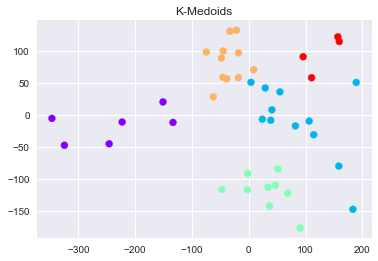

In [366]:
plt.scatter(x,y, c=kmedoids_cluster, cmap='rainbow')
plt.title("K-Medoids")

Text(0.5,1,'K-Means')

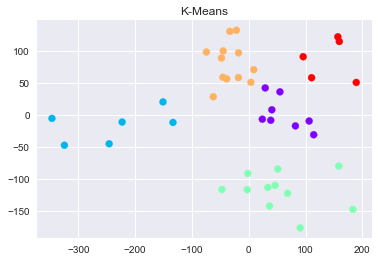

In [361]:
plt.scatter(x,y, c=kmeans.labels_, cmap='rainbow')
plt.title("K-Means")

In [345]:
print(out)
print(kmeans.labels_)
print(k_medoids_cluter)

[[-346.57257051   -5.90610156]
 [-133.43378465  -12.21238493]
 [-222.96147795  -11.57237917]
 [-245.80136883  -45.57492439]
 [-151.04771512   19.88149584]
 [ -62.44759432   27.90485803]
 [-324.57520321  -47.85645228]
 [   8.74344767   70.29350457]
 [ -18.06596449   96.61821617]
 [ -38.85860333   55.98215136]
 [  38.7033614    -8.85734528]
 [ 106.32729169  -10.00136069]
 [ 114.31166403  -31.4404848 ]
 [  82.10889676  -17.61884409]
 [  -1.79045141  -91.94803312]
 [  68.27364464 -122.94047207]
 [   3.77825954   50.49340969]
 [  23.86325721   -7.13023849]
 [  40.63578357    7.56002942]
 [  -2.67751974 -117.20343752]
 [ -47.34260483 -117.03584076]
 [  33.49314957 -113.79907916]
 [  54.87541043   35.65206542]
 [  51.09674649  -85.00558774]
 [ -74.57865611   97.84744846]
 [ -18.22125132   57.96278174]
 [ -33.32082978  130.18005743]
 [ -48.10415991   88.45431895]
 [ -45.05957809   99.62518304]
 [ -45.61739494   58.37932595]
 [ -21.84728262  131.90587974]
 [ 110.57949851   57.72316992]
 [ 189.2

NameError: name 'k_medoids_cluter' is not defined